# EDA Using Unsupervised Learning - Hierarchical Clustering

The following notebooks implements exploratory data analysis using unsupervised learning method - hierarchical clustering.

Some of the code that has been used to perform hierarchical clustering can be found under following link:

https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis



In [1]:
# Import standard libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the hierarchical clustering algorithm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from pandas.plotting import parallel_coordinates
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the data set
#data = pd.read_csv('/content/drive/MyDrive/Term2/CS5812/Files/Europe COVID statistics.csv', header = 0, index_col = 'date')
data = pd.read_csv('/content/drive/MyDrive/CS5812/Europe COVID statistics.csv', header = 0, index_col = 'date')
data.head()

Unnamed: 0     X  country iso3c  confirmed  deaths  recovered  \
date                                                                        
2020-01-22        1513  1513  Albania   ALB          0       0          0   
2020-01-23        1514  1514  Albania   ALB          0       0          0   
2020-01-24        1515  1515  Albania   ALB          0       0          0   
2020-01-25        1516  1516  Albania   ALB          0       0          0   
2020-01-26        1517  1517  Albania   ALB          0       0          0   

            new.d  new.c  new.r  population  death_rate  recovery_rate  \
date                                                                     
2020-01-22      0      0      0     2877800         0.0            0.0   
2020-01-23      0      0      0     2877800         0.0            0.0   
2020-01-24      0      0      0     2877800         0.0            0.0   
2020-01-25      0      0      0     2877800         0.0            0.0   
2020-01-26      0      0      0     2877800         0.0            0.0   

            infection_rate continent  
date                                  
2020-01-22             0.0        EU  
2020-01-23             0.0        EU  
2020-01-24             0.0        EU  
2020-01-25             0.0        EU  
2020-01-26             0.0        EU

Import necessary functions created for this course

In [5]:
def plot_dendrogram(Z, names, figsize=(10,25)):
    '''Plot a dendrogram to illustrate hierarchical clustering'''

    plt.figure(figsize=figsize)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    #plt.show()

In [6]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

In [7]:
def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)  

In [8]:
def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)

In [9]:
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

In [10]:
palette = sns.color_palette("bright", 10)

In [11]:
# Get rid of unnecessary columns
X = data.drop({'Unnamed: 0', 'X', 'iso3c', 'population', 'continent'}, axis = 1)
X.head()

country  confirmed  deaths  recovered  new.d  new.c  new.r  \
date                                                                     
2020-01-22  Albania          0       0          0      0      0      0   
2020-01-23  Albania          0       0          0      0      0      0   
2020-01-24  Albania          0       0          0      0      0      0   
2020-01-25  Albania          0       0          0      0      0      0   
2020-01-26  Albania          0       0          0      0      0      0   

            death_rate  recovery_rate  infection_rate  
date                                                   
2020-01-22         0.0            0.0             0.0  
2020-01-23         0.0            0.0             0.0  
2020-01-24         0.0            0.0             0.0  
2020-01-25         0.0            0.0             0.0  
2020-01-26         0.0            0.0             0.0

In [12]:
# Encode the 'country' column into numeric form
label = LabelEncoder()
X['country'] = label.fit_transform(X['country'])

In [13]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-1.69397911, -0.43511867, -0.44319058, ..., -0.48356632,
        -0.3065271 , -0.5650713 ],
       [-1.69397911, -0.43511867, -0.44319058, ..., -0.48356632,
        -0.3065271 , -0.5650713 ],
       [-1.69397911, -0.43511867, -0.44319058, ..., -0.48356632,
        -0.3065271 , -0.5650713 ],
       ...,
       [-0.4619943 , -0.43509064, -0.44319058, ..., -0.48356632,
        -0.3065271 , -0.5650713 ],
       [-0.4619943 , -0.43509064, -0.44319058, ..., -0.48356632,
        -0.3065271 , -0.5650713 ],
       [-0.4619943 , -0.43509064, -0.44319058, ..., -0.48356632,
        -0.3065271 , -0.5650713 ]])

### Perform Hierarchical Clustering:

In [14]:
# Create a hierarchical clustering model
hiercluster = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree=True)  

In [15]:
# Fit the data to the model and determine which clusters each data point belongs to:
hiercluster.set_params(n_clusters = 4)
clusters = hiercluster.fit_predict(X_scaled) 
np.bincount(clusters) # count of data points in each cluster

array([ 1815, 13155,  1227,  9048])

In [16]:
# Read off 4 clusters: (five have also been tried)
hiercluster.set_params(n_clusters = 4)
clusters = hiercluster.fit_predict(X_scaled) 
np.bincount(clusters)

array([ 1815, 13155,  1227,  9048])

In [17]:
# Add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clusters

X_scaled_clustered.head()

country  confirmed    deaths  recovered     new.d     new.c  \
date                                                                       
2020-01-22 -1.693979  -0.435119 -0.443191  -0.341405 -0.359211 -0.371767   
2020-01-23 -1.693979  -0.435119 -0.443191  -0.341405 -0.359211 -0.371767   
2020-01-24 -1.693979  -0.435119 -0.443191  -0.341405 -0.359211 -0.371767   
2020-01-25 -1.693979  -0.435119 -0.443191  -0.341405 -0.359211 -0.371767   
2020-01-26 -1.693979  -0.435119 -0.443191  -0.341405 -0.359211 -0.371767   

               new.r  death_rate  recovery_rate  infection_rate  cluster  
date                                                                      
2020-01-22 -0.314427   -0.483566      -0.306527       -0.565071        3  
2020-01-23 -0.314427   -0.483566      -0.306527       -0.565071        3  
2020-01-24 -0.314427   -0.483566      -0.306527       -0.565071        3  
2020-01-25 -0.314427   -0.483566      -0.306527       -0.565071        3  
2020-01-26 -0.314427   -0.483566      -0.306527       -0.565071        3

In [18]:
# Find the size of the clusters
X_scaled_clustered["cluster"].value_counts()

1    13155
3     9048
0     1815
2     1227
Name: cluster, dtype: int64

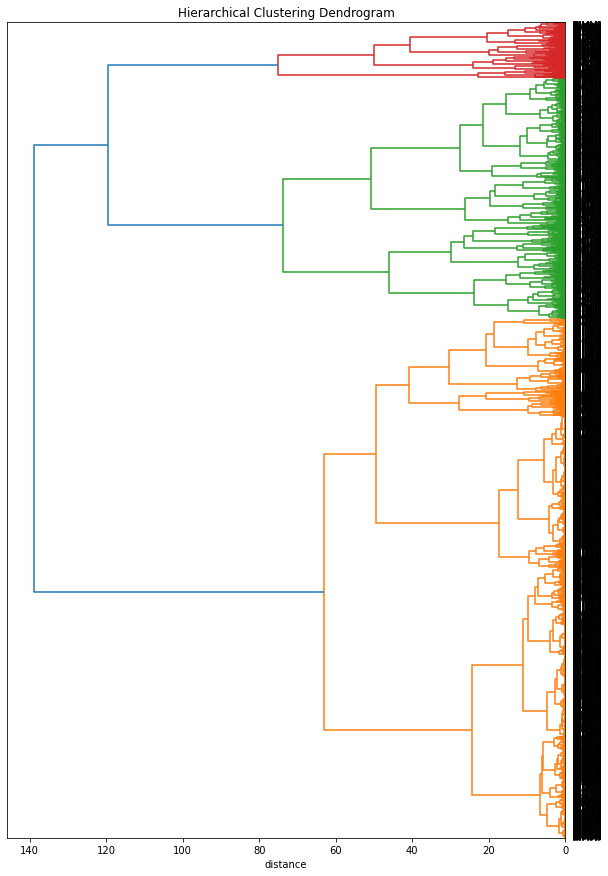

In [19]:
# Show a dendrogram, just for the first smallest cluster
from scipy.cluster.hierarchy import linkage, fcluster 
sample = X_scaled_clustered[X_scaled_clustered.cluster==1]
Z = linkage(sample, 'ward') 
names = sample.index 
plot_dendrogram(Z, names, figsize=(10,15))

In [21]:
from sklearn.decomposition import PCA

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Transform the scaled data to the new PCA space
X_reduced = pca.transform(X_scaled)

In [22]:
# Data frame with principal components:

X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = clusters
X_reduceddf.head()

PC1       PC2  cluster
date                                   
2020-01-22 -1.272206 -0.362402        3
2020-01-23 -1.272206 -0.362402        3
2020-01-24 -1.272206 -0.362402        3
2020-01-25 -1.272206 -0.362402        3
2020-01-26 -1.272206 -0.362402        3

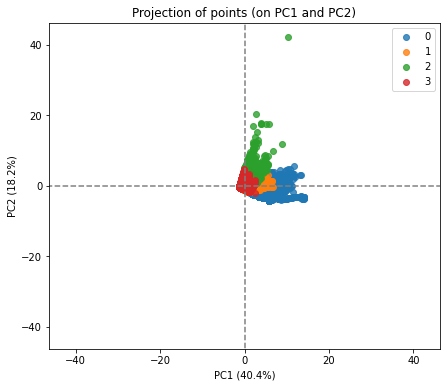

In [23]:
display_factorial_planes(X_reduced, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)

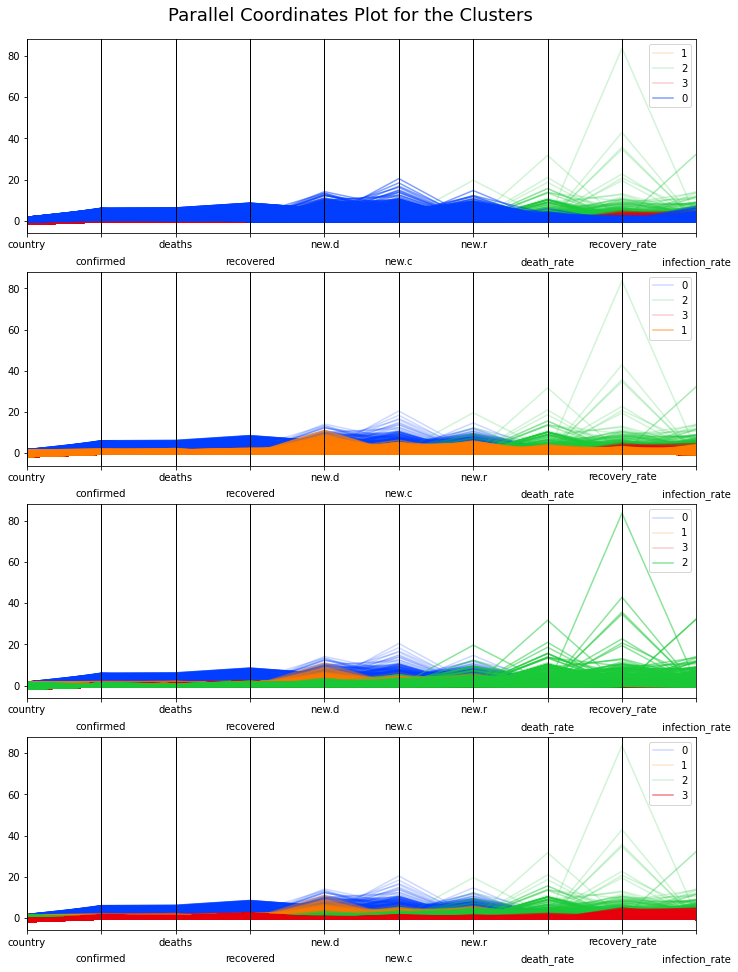

In [24]:
# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered["cluster"] = clusters

# Display parallel coordinates plots, one for each cluster
display_parallel_coordinates(X_clustered, 4)

In [25]:
# Compute centroids in each cluster:
means =  X_clustered.groupby(by="cluster").mean()

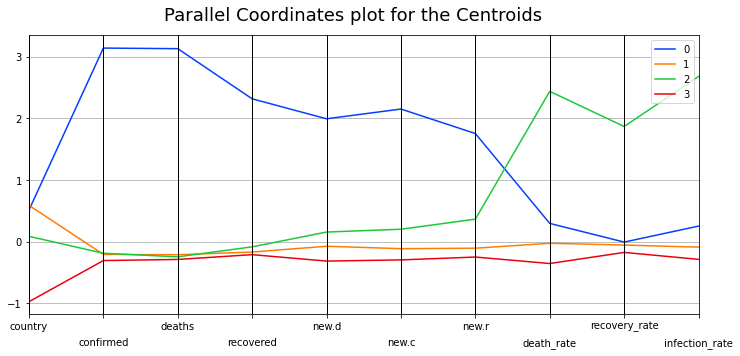

In [26]:
# Display parallel coordinates for the centroids:
display_parallel_coordinates_centroids(means.reset_index(), 5)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd65e857a50>,
      dtype=object)

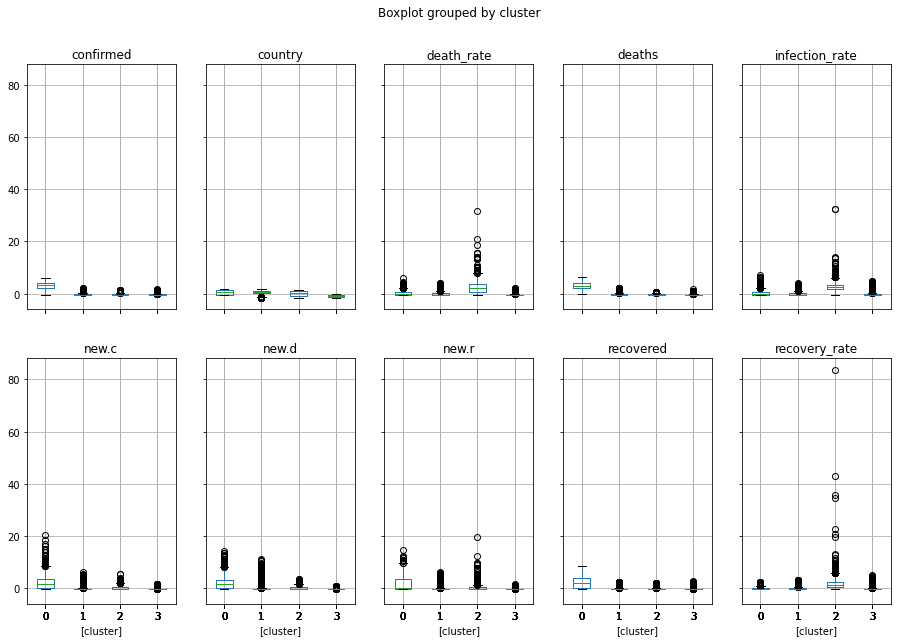

In [27]:
X_clustered.boxplot(by="cluster", figsize=(15,10), layout=(2,5))